# Prognostics using Autoencoder

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
from addutils import css_notebook
css_notebook()

## 1. Introduction

An autoencoder is an artificial neural network for learning an efficient encoding. The network will learn a representation for a set of data. 

![](images/Autoencoder_structure.png)

The basic idea as can be seen above is that you have a first part of the network called **encoder** which will learn to create an encoding *z* of the input *X*. The second part, the **decoder**, will learn to recreate the *X* as *X'* from the encoding *z*. In other words, the goal is to minimize the difference between the input *X* and the output *X'*.


In this notebook we will use an autoencoder to learn an encoding of 26 signals from turbo fan engines within a window of 26 timesteps. We will then use this encoding to predict breakdown of the turbo fan and make a visualization of the current state of the turbo fan. We will use Tensorflow as our deep learning framework

## 2. Dataset

The dataset we will use can be found at https://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/ It is number 6 in the list and is called Turbofan Engine Degradation Simulation Data Set.

Download the data set and update **DATA_DIR** below to point to the correct directory.

In [3]:
import os
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf

DATA_DIR = "/mnt/hdd_data/nasa/turbofan_engine/CMAPSSData" 
HEADER_NAMES = ["unit", "time", "op_set_1", "op_set_2", "op_set_3"] + ["sensor_%02d" % i for i in range(1,24)]

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


First we take a look at the data using pandas.

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, "train_FD001.txt"), sep=" ", index_col=None, header=None, names=HEADER_NAMES)

print("First five rows")
print(df.head(5))

print("\n Unique units (engines)")
print(df["unit"].unique())

First five rows
   unit  time  op_set_1  op_set_2  op_set_3  sensor_01  sensor_02  sensor_03  \
0     1     1   -0.0007   -0.0004     100.0     518.67     641.82    1589.70   
1     1     2    0.0019   -0.0003     100.0     518.67     642.15    1591.82   
2     1     3   -0.0043    0.0003     100.0     518.67     642.35    1587.99   
3     1     4    0.0007    0.0000     100.0     518.67     642.35    1582.79   
4     1     5   -0.0019   -0.0002     100.0     518.67     642.37    1582.85   

   sensor_04  sensor_05    ...      sensor_14  sensor_15  sensor_16  \
0    1400.60      14.62    ...        8138.62     8.4195       0.03   
1    1403.14      14.62    ...        8131.49     8.4318       0.03   
2    1404.20      14.62    ...        8133.23     8.4178       0.03   
3    1401.87      14.62    ...        8133.83     8.3682       0.03   
4    1406.22      14.62    ...        8133.80     8.4294       0.03   

   sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  sensor_22  sensor_

We create some functions to load train and test data.

In [5]:
def train_data(set_number, with_rul=False, with_rul_class=False):
    filepath = os.path.join(DATA_DIR, "train_FD00%s.txt" % (set_number))
    df = pd.read_csv(filepath, sep=" ", index_col=None, header=None, names=HEADER_NAMES)
    df.fillna(0, inplace=True)

    if with_rul:
        df["RUL"] = None

        for unit, df_unit in df.groupby("unit"):
            until_failure = df_unit["time"].max()            
            df.loc[df_unit.index, "RUL"] = until_failure - df_unit["time"]

        if with_rul_class:
            df["RUL_class"] = "normal"
            for name, level in LEVELS:
                df.loc[df["RUL"] < level, "RUL_class"] = name

    return df

def test_data(set_number, with_rul=False):
    filepath = os.path.join(DATA_DIR, "test_FD00%s.txt" % (set_number))
    df = pd.read_csv(filepath, sep=" ", index_col=None, header=None, names=HEADER_NAMES)
    df.fillna(0, inplace=True)

    return df

Plot a specific unit.

In [6]:
def plot_unit(set_number, unit):
    df = train_data(set_number, with_rul=True)

    ignore_cols = ["unit", "time", "RUL"]
    units = [unit]
        
    fig, ax = plt.subplots(1)
    ax = [ax]    

    for i, (unit, df_unit) in enumerate(df[df["unit"].isin(units)].groupby("unit")):

        rul = df_unit["RUL"].values
        labels = [c for c in df_unit.columns if not c in ignore_cols]

        x = df_unit[labels].values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)

        for values in x_scaled.T:
            ax[i].plot(rul, values)
            #ax[i].invert_xaxis()
            ax[i].set_xlim(max(rul), 0)
            ax[i].set_title("Unit %d" % unit)
            ax[i].set_xlabel('Remaining Useful Life (RUL)')
            ax[i].set_ylabel('normalized values')

    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

Plotting the 26 signals of unit 5 and 63 in dataset 1 called FD001.

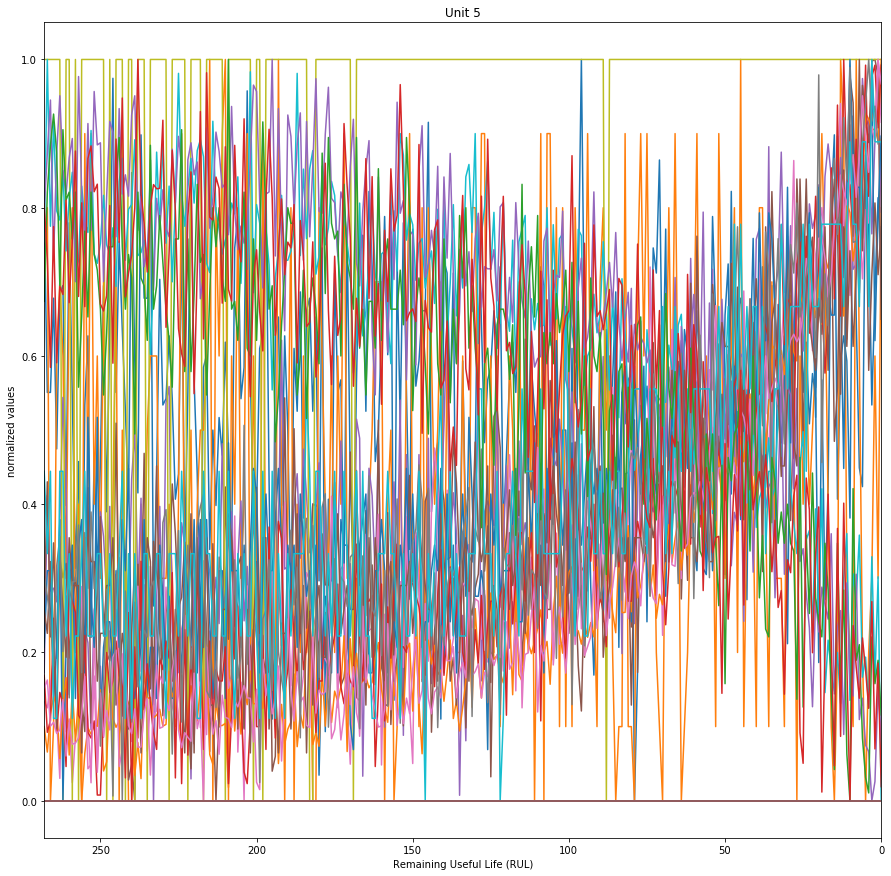

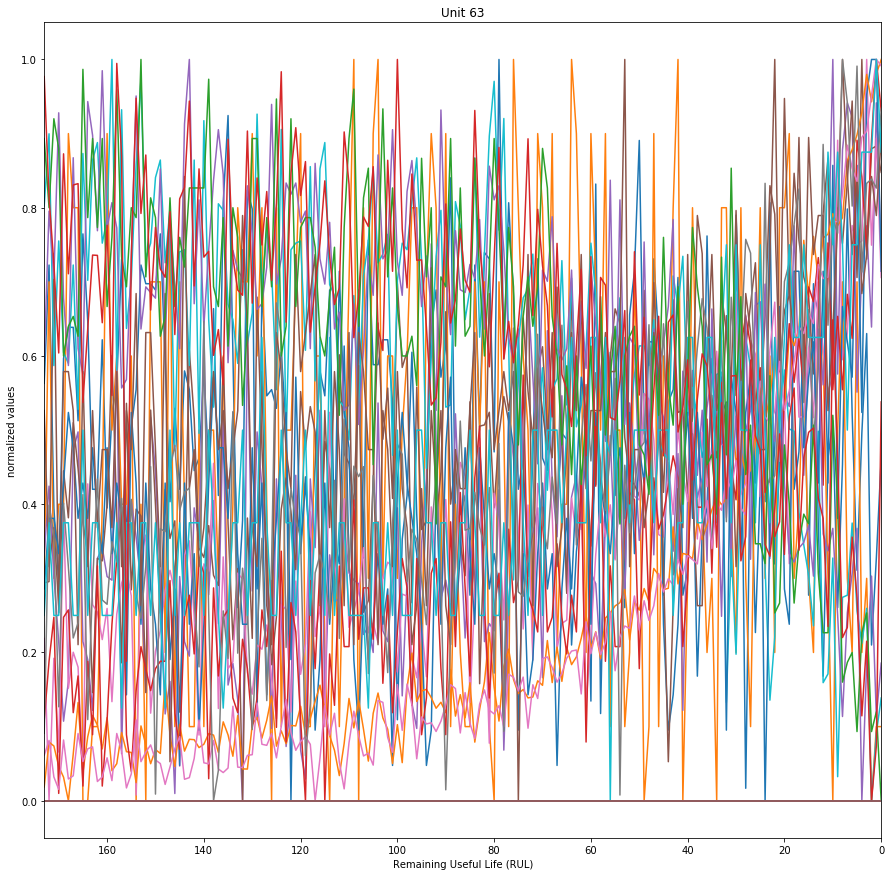

In [7]:
plot_unit(1, 5)
plot_unit(1, 63)

The x-axis tells us how many timesteps are left before the engine breaks down. These two units have data of different length, ~260 and ~170 timesteps respectively. By looking at these two graphs you can kind of tell when the remaining useful life starts to diminish. But our goal with this exercise is to learn an encoding which makes it more obvious.

## 3. One layer Autoencoder

### 3.1 Train autoencoder

The first step is to train an autoencoder. We will use all the of the 26 signals and a window of 26 timesteps. Meaning the vector we are trying to encode contains 26*26 = 676 values. The autoencoder will learn a simplified encoding of this vector.

![](images/enc_base.png)

First we create some helper classes and functions which will load and iterate the data.

In [8]:
class DataIterator(object):

    def __init__(self, df):
        self.size = 26
        self.df = df
        self.n_input = self.size*self.size

    def __iter__(self):

        for unit, df_unit in self.df.groupby("unit"):            
            arr = df_unit[df_unit.columns.difference(["unit", "time"])].as_matrix()
            for i in range(arr.shape[0] - self.size):
                yield arr[i:i+self.size].reshape(-1)

    def iter_series(self):

        for unit, df_unit in self.df.groupby("unit"):
            time_values = df_unit["time"].values            
            arr = df_unit[df_unit.columns.difference(["unit", "time"])].as_matrix()            
            vectors = [arr[i:i+self.size].reshape(-1) for i in range(arr.shape[0] - self.size)]
            yield unit, time_values[-len(vectors):], vectors


def autoencoder_train_set(sets, with_rul=False, with_rul_class=False):
    arrs = []
    for i in sets:
        x = np.array(list(DataIterator(train_data(i, with_rul, with_rul_class))))
        arrs.append(x)
    return np.vstack(arrs)


def autoencoder_test_set(sets):
    arrs = []
    for i in sets:
        x = np.array(list(DataIterator(test_data(i))))
        arrs.append(x)
    return np.vstack(arrs)

def standard_scale(X_train, X_test):
    preprocessor = preprocessing.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

Now we create our autoencoder which will have just one hidden layer which will also represent the encoding.

In [9]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval = low, maxval = high,
                             dtype = tf.float32)

class Autoencoder(object):

    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus, optimizer = tf.train.AdamOptimizer()):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x, self.weights['w1']), self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)


    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype=tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict={self.x: X})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size=self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict={self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [10]:
def train_autoencoder(sets, kind="base", batch_size=128, epochs=20, n_hidden=200):

    # https://github.com/tensorflow/models/blob/master/autoencoder/AutoencoderRunner.py
    
    if isinstance(n_hidden, list):
        filename = "autoencoder_%s_%s_n%3s_e%d" % (kind, "-".join(map(str, sorted(sets))), "-".join(map(str, n_hidden)), epochs)
    else:
        filename = "autoencoder_%s_%s_n%3d_e%d" % (kind, "-".join(map(str, sorted(sets))), n_hidden, epochs)


    X_train = autoencoder_train_set(sets)
    X_test = autoencoder_test_set(sets)


    X_train, X_test = standard_scale(X_train, X_test)

    display_step = 1
    n_samples = X_train.shape[0]
    n_input = X_train.shape[1]
    classes = 5

    if kind == "base":
        autoencoder = Autoencoder(n_input = n_input,
                                    n_hidden = n_hidden,
                                    transfer_function = tf.nn.softplus,
                                    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001))
    elif kind == "deep":
        autoencoder = DeepEncoder(n_input = n_input,
                                    classes=classes,
                                    n_hidden = n_hidden,
                                        transfer_function = tf.nn.softplus,
                                        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001))


    t1 = time.time()
    costs = []
    for epoch in range(epochs):
        avg_cost = 0.
        costs = []
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = get_random_block_from_data(X_train, batch_size)

            # Fit training using batch data
            cost = autoencoder.partial_fit(batch_xs)
            costs.append(cost)
            # Compute average loss
        #    avg_cost += cost / n_samples * batch_size
        avg_cost = np.mean(costs)
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), \
                "cost=", "{:.9f}".format(avg_cost))
    
    t2 = time.time()
    print("Training took: %s" % (t2-t1))
    #print "Total cost: " + str(autoencoder.calc_total_cost(X_test))

    saver = tf.train.Saver()
    save_path = saver.save(autoencoder.sess, "data/%s" % (filename))
    print("Saved to:", save_path)

Let's train our autoencoder. We start with a simple one having just one hidden layer. Training this model for 50 epochs using a Titan X Pascal takes about 30 seconds.

In [11]:
train_autoencoder(sets="1", kind="base", batch_size=128, epochs=50, n_hidden=200)

Epoch: 0001 cost= 13177.837890625
Epoch: 0002 cost= 8698.487304688
Epoch: 0003 cost= 6831.282226562
Epoch: 0004 cost= 5865.803710938
Epoch: 0005 cost= 6058.212402344
Epoch: 0006 cost= 5092.137695312
Epoch: 0007 cost= 4813.267089844
Epoch: 0008 cost= 4760.778808594
Epoch: 0009 cost= 4476.427734375
Epoch: 0010 cost= 4277.719238281
Epoch: 0011 cost= 4429.517578125
Epoch: 0012 cost= 4117.052246094
Epoch: 0013 cost= 3925.017822266
Epoch: 0014 cost= 4052.713378906
Epoch: 0015 cost= 4138.117187500
Epoch: 0016 cost= 3896.892333984
Epoch: 0017 cost= 3817.821044922
Epoch: 0018 cost= 3991.079345703
Epoch: 0019 cost= 3820.648681641
Epoch: 0020 cost= 3939.526855469
Epoch: 0021 cost= 4162.628906250
Epoch: 0022 cost= 3775.476318359
Epoch: 0023 cost= 3833.658935547
Epoch: 0024 cost= 4059.401367188
Epoch: 0025 cost= 3947.285644531
Epoch: 0026 cost= 3646.758300781
Epoch: 0027 cost= 3667.372314453
Epoch: 0028 cost= 3757.052734375
Epoch: 0029 cost= 3584.195068359
Epoch: 0030 cost= 3891.581298828
Epoch: 00

### 2.3. Train a classifier

Train a classifier using the code from the autoencoder trained above and 5 classes depending on the current state, timesteps until breakdown.

![](images/classifier.png)

- First warning is given 100 timesteps before breakdwon
- second 50
- third 30
- and final alert 15 timesteps before breakdown

In [12]:
LEVELS = [
    ("warning-1", 100),
    ("warning-2", 50),
    ("warning-3", 30),
    ("alert", 15)
]
LABEL_ENCODING = {
    "normal": [1,0,0,0,0],
    "warning-1": [0,1,0,0,0],
    "warning-2": [0,0,1,0,0],
    "warning-3": [0,0,0,1,0],
    "alert": [0,0,0,0,1],
}
N_CLASSES = len(LEVELS) + 1


class AutoencodeIterator(object):

    def __init__(self, df, y_col, encoder):
        self.size = 26
        self.y_col = y_col
        self.df = df
        self.n_input = self.size*self.size
        n_input = self.size*self.size        
        n_hidden = 200
        self.encoder = encoder


    def __iter__(self):        

        for unit, df_unit in self.df.groupby("unit"):
            df_unit = df_unit[df_unit.columns.difference(["unit", "time"])]

            if self.y_col is None:
                y = None
            else:
                y = df_unit[self.y_col].as_matrix()[self.size:]
                if self.y_col == "RUL_class":
                    y = np.array([LABEL_ENCODING[label] for label in y])
                else:
                    y = np.reshape(y, (y.shape[0], 1))

            arr = df_unit[df_unit.columns.difference(["RUL", "RUL_class"])].as_matrix()

            X = []
            for i in range(self.size, arr.shape[0]):
                x = arr[i-self.size:i].reshape(-1)
                X.append(x)

            X = np.array(X)
            X = self.encoder.transform(X)

            if y is None:
                yield X
            else:
                yield X, y

def classifier_data(sets, encoder):
    x_arrs = []
    y_arrs = []
    for i in sets:
        for X,y in AutoencodeIterator(train_data(i, with_rul=True, with_rul_class=True), "RUL_class", encoder):
            x_arrs.append(X)
            y_arrs.append(y)

    return np.vstack(x_arrs), np.vstack(y_arrs)

def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval = low, maxval = high,
                             dtype = tf.float32)



class Encoder(object):

    def __init__(self, n_input, classes, n_hidden, model=None):
        # Restore variables from disk.
        self.autoencoder = Autoencoder(n_input = n_input,
                                        n_hidden = n_hidden,
                                        transfer_function = tf.nn.softplus,
                                        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
                                        )
        if model:
            saver = tf.train.import_meta_graph("%s.meta" % model)
            saver.restore(self.autoencoder.sess, model)

    def transform(self, X):
        return self.autoencoder.transform(X)


class AEClassifier(object):

    def __init__(self, n_input, classes, learning_rate=0.1, model=None):

        tf.reset_default_graph()

        # TF graph input
        self.Xph = tf.placeholder("float", shape=(None, n_input))
        self.Yph = tf.placeholder("float", shape=(None, classes))

        # Set model weights
        self.W = tf.Variable(tf.zeros([n_input, classes]),name="W")
        self.b = tf.Variable(tf.zeros([classes]), name="b")

        # Construct a classifier
        self.y = tf.nn.softmax(tf.matmul(self.Xph, self.W) + self.b)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yph * tf.log(self.y), reduction_indices=[1]))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cross_entropy) #Gradient descent

        init = tf.initialize_all_variables()
        self.sess = tf.Session()
        self.sess.run(init)

        if model:
            saver = tf.train.import_meta_graph("%s.meta" % model)
            saver.restore(self.sess, model)

    def partial_fit(self, X, y):
        cost = self.sess.run([self.optimizer, self.cross_entropy], feed_dict={self.Xph: X, self.Yph: y})[1]
        return cost

    def predict(self, X):
        y_pred = self.sess.run(self.y, feed_dict={self.Xph: X})
        return y_pred

    def save(self, filepath):
        saver = tf.train.Saver()
        save_path = saver.save(self.sess, filepath)

def train_classifier(sets, kind, autoencoder_filepath, epochs=20,):

    n_input = 26*26
    classes = N_CLASSES
    # Set parameters
    n_hidden = 200
    display_step = 1
    learning_rate = 0.1
    training_iteration = 200
    batch_size = 128

    if kind == "base":
        encoder = Encoder(n_input, classes, n_hidden, autoencoder_filepath)
    elif kind == "deep":
        n_hidden = [256,128]
        encoder = DeepEncoder(n_input, classes, n_hidden, model=autoencoder_filepath)

    print("Loading data..")
    X,Y = classifier_data(sets, encoder)
    scaler = preprocessing.StandardScaler()
    print("Scaling data..")
    X = scaler.fit_transform(X,Y)

    print("Splitting data..")
    X_train, X_test, y_train, y_test = train_test_split(X,Y)

    samples_number = X_train.shape[0]

    model = AEClassifier(X.shape[1], classes, learning_rate)

    t1 = time.time()
    for epoch in range(epochs):

        total_batch = int(samples_number / batch_size)
        costs = []
        # Loop over all batches
        for i in range(total_batch):
            start_index = np.random.randint(0, samples_number - batch_size)
            x_batch = X_train[start_index:start_index+batch_size]
            y_batch = y_train[start_index:start_index+batch_size]
            cost = model.partial_fit(x_batch, y_batch)
            costs.append(cost)

        avg_cost = np.mean(costs)

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), \
                "cost=", "{:.9f}".format(avg_cost))
    t2 = time.time()
    print("Training took: %s" % (t2-t1))

    filename = "autoencoder_%s_classifier_%s" % (kind, "-".join(map(str,sets)))
    model_filepath = os.path.join("data", filename)
    print("Saving model to", model_filepath)
    model.save(model_filepath)


    print("Computing class probabilites")
    for set_number in sets:
        df = train_data(set_number)
        di = DataIterator(df)
        values = []
        for unit, time_values, ts in di.iter_series():

            unit_values = np.zeros(shape=(len(ts), 7))
            unit_values[:, 0] = unit

            X = encoder.transform(ts)
            X = scaler.transform(X)
            y_pred = model.predict(X)
            y_pred

            for i in range(len(ts)):
                unit_values[i, 1] = time_values[i]
                unit_values[i, 2:7] = y_pred[i]

            values.append(unit_values)

        values = np.vstack(values)

        columns = ["unit", "time", "normal", "warning-1", "warning-2", "warning-3", "alert"]
        df_probs = pd.DataFrame(values, columns=columns)
        probs_filepath = "data/probs_%s_%s.csv" % (kind, set_number)
        print("Saving class probs to", probs_filepath)
        df_probs.to_csv(probs_filepath, columns=columns, index=None)

Training this classifier using a Titan X Pascal takes just a couple of seconds.

In [13]:
train_classifier("1", "base", "data/autoencoder_base_1_n200_e50", epochs=30)

Loading data..
Scaling data..
Splitting data..
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0001 cost= 0.992481649
Epoch: 0002 cost= 0.881969631
Epoch: 0003 cost= 0.848856151
Epoch: 0004 cost= 0.823933125
Epoch: 0005 cost= 0.805802405
Epoch: 0006 cost= 0.787849069
Epoch: 0007 cost= 0.778528094
Epoch: 0008 cost= 0.779422343
Epoch: 0009 cost= 0.763610721
Epoch: 0010 cost= 0.754846573
Epoch: 0011 cost= 0.772828817
Epoch: 0012 cost= 0.762471378
Epoch: 0013 cost= 0.755534887
Epoch: 0014 cost= 0.752195895
Epoch: 0015 cost= 0.738073051
Epoch: 0016 cost= 0.738060892
Epoch: 0017 cost= 0.727453351
Epoch: 0018 cost= 0.745861173
Epoch: 0019 cost= 0.738626599
Epoch: 0020 cost= 0.740079224
Epoch: 0021 cost= 0.731570244
Epoch: 0022 cost= 0.716791451
Epoch: 0023 cost= 0.731779397
Epoch: 0024 cost= 0.730556965
Epoch: 0025 cost= 0.725127816
Epoch: 0026 cost= 0.719237745
Epoch: 0027 cost= 0.726095796
Epoch: 0028 cost= 0.726223826
Epoch: 0029 cost= 0.721588492
Epoch: 00

### 3.3. Classify & Plot 

Plots the probability for each class at each timestep for 6 units. At each timestep the total probability for all classes (states) will be 1.0. As we will hopefully see, in the begin the probability will be highest for "normal" state while towards the end the "alert" state will rise. 

In [14]:
import matplotlib.patches as mpatches
from scipy.signal import savgol_filter

def plot_series_probs(series):    
    colors = ["green","yellowgreen","gold", "darkorange", "red"]
    labels = ["normal", "warning-1", "warning-2", "warning-3", "alert"]

    handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]

    fig, ax = plt.subplots(3,2)
    ax = [x for l in ax for x in l]    

    for i, (unit, probs) in enumerate(series):

        for color, values in zip(colors, probs):
            rul = list(reversed(range(len(values))))
            values = savgol_filter(values, 15, 3)
            ax[i].plot(rul, values, color=color, linewidth=5)
            ax[i].invert_xaxis()
            ax[i].set_title("Unit %d" % unit)
            ax[i].set_ylabel('Probability')
            ax[i].set_xlabel('Remaining Useful Life (RUL)')
            if i == 0:
                ax[i].legend(handles=handles, loc="upper left")

    fig.subplots_adjust(hspace=0.4, wspace=0.2)    
    plt.show()

def plot_probs(filepath, units=None):

    df = pd.read_csv(filepath)

    if units is None:
        units = np.random.choice(df["unit"].unique(), 6)
    elif len(units) > 6:
        units = units[:6]

    series = []
    for unit, df_unit in df[df["unit"].isin(units)].groupby("unit"):
        probs = df_unit[["normal", "warning-1", "warning-2", "warning-3", "alert"]].as_matrix()
        series.append((unit, probs.T))    

    plot_series_probs(series)

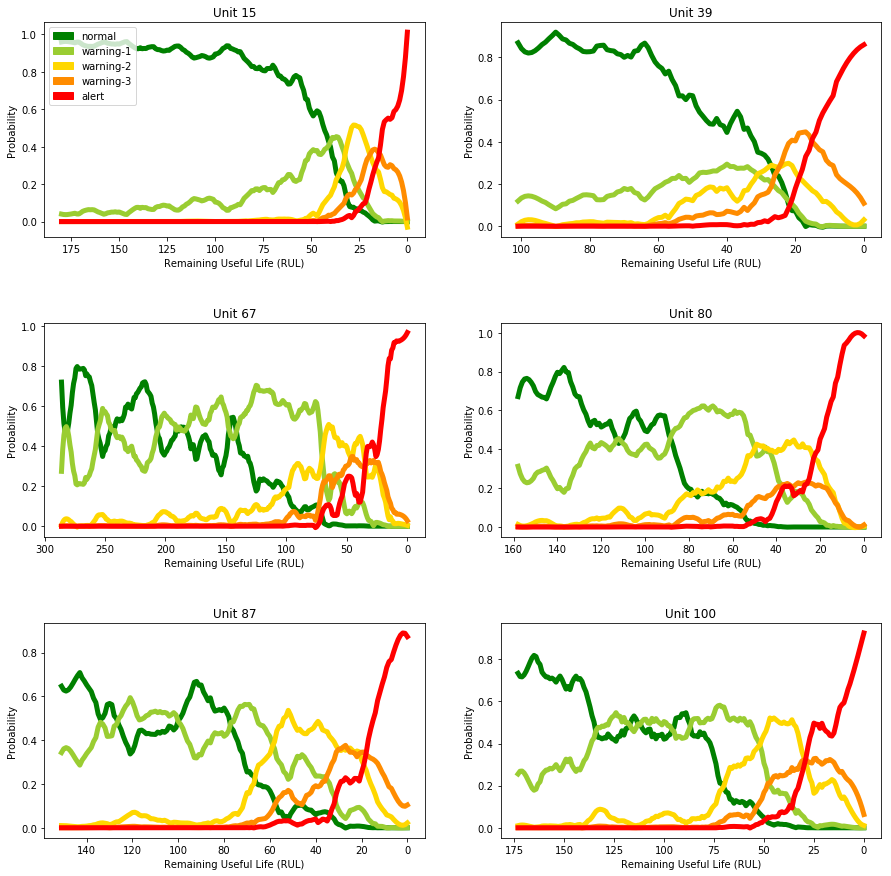

In [15]:
plot_probs("data/probs_base_1.csv", units=[15, 39, 67, 80, 87, 100])

## 4. A deeper Autoencoder

The previous autoencoder used just one hidden layer. Let's create an autoencoder using three hidden layers instead. The code will be represented by the middle layer like the picture below.

![](images/enc_deep.png)

In [16]:
class DeepEncoder(object):

    def __init__(self, n_input, classes, n_hidden, transfer_function=tf.nn.softplus, optimizer = tf.train.AdamOptimizer(), model=None):
        self.n_input = n_input
        self.depth = len(n_hidden)
        self.n_hidden = n_hidden
        self.transfer = transfer_function

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden1 = self.transfer(tf.add(tf.matmul(self.x, self.weights['w1']), self.weights['b1']))
        self.hidden2 = self.transfer(tf.add(tf.matmul(self.hidden1, self.weights['w2']), self.weights['b2']))
        self.reconstruction1 = tf.add(tf.matmul(self.hidden2, self.weights['w3']), self.weights['b3'])
        self.reconstruction2 = tf.add(tf.matmul(self.reconstruction1, self.weights['w4']), self.weights['b4'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction2, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

        if model:
            saver = tf.train.import_meta_graph("%s.meta" % model)
            saver.restore(self.sess, model)

    def _initialize_weights(self):
        all_weights = dict()

        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden[0]))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden[0]], dtype=tf.float32))

        all_weights['w2'] = tf.Variable(xavier_init(self.n_hidden[0], self.n_hidden[1]))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_hidden[1]], dtype=tf.float32))

        all_weights['w3'] = tf.Variable(xavier_init(self.n_hidden[1], self.n_hidden[0]))
        all_weights['b3'] = tf.Variable(tf.zeros([self.n_hidden[0]], dtype=tf.float32))

        all_weights['w4'] = tf.Variable(xavier_init(self.n_hidden[0], self.n_input))
        all_weights['b4'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))

        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def transform(self, X):
        return self.sess.run(self.hidden2, feed_dict={self.x: X})

Training a model with more layers takes a little bit longer, about 43 seconds on a Titan X Pascal.

In [17]:
print("\n### Training autoencoder\n")
train_autoencoder(sets="1", kind="deep", batch_size=128, epochs=50, n_hidden=[256, 128])


### Training autoencoder

Epoch: 0001 cost= 15262.564453125
Epoch: 0002 cost= 11547.779296875
Epoch: 0003 cost= 11282.883789062
Epoch: 0004 cost= 9763.460937500
Epoch: 0005 cost= 9341.160156250
Epoch: 0006 cost= 8275.237304688
Epoch: 0007 cost= 7752.011718750
Epoch: 0008 cost= 7958.185546875
Epoch: 0009 cost= 7478.539550781
Epoch: 0010 cost= 7155.635253906
Epoch: 0011 cost= 7701.113281250
Epoch: 0012 cost= 7241.648437500
Epoch: 0013 cost= 6568.755371094
Epoch: 0014 cost= 6695.643066406
Epoch: 0015 cost= 6237.249511719
Epoch: 0016 cost= 6727.392089844
Epoch: 0017 cost= 6261.428710938
Epoch: 0018 cost= 6305.251953125
Epoch: 0019 cost= 6267.385742188
Epoch: 0020 cost= 6131.586425781
Epoch: 0021 cost= 6189.112304688
Epoch: 0022 cost= 6671.174316406
Epoch: 0023 cost= 5892.417480469
Epoch: 0024 cost= 5812.458984375
Epoch: 0025 cost= 6305.439453125
Epoch: 0026 cost= 5908.481933594
Epoch: 0027 cost= 5795.268066406
Epoch: 0028 cost= 5816.203613281
Epoch: 0029 cost= 6128.157226562
Epoch: 0030 c

In [18]:
print("\n### Training classifier\n")
train_classifier("1", "deep", "data/autoencoder_deep_1_n256-128_e50", epochs=30)


### Training classifier

Loading data..
Scaling data..
Splitting data..
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0001 cost= 1.002147436
Epoch: 0002 cost= 0.889206290
Epoch: 0003 cost= 0.838309646
Epoch: 0004 cost= 0.814942598
Epoch: 0005 cost= 0.807918608
Epoch: 0006 cost= 0.798351228
Epoch: 0007 cost= 0.789499760
Epoch: 0008 cost= 0.785826981
Epoch: 0009 cost= 0.783359826
Epoch: 0010 cost= 0.769744515
Epoch: 0011 cost= 0.760195136
Epoch: 0012 cost= 0.768474042
Epoch: 0013 cost= 0.753258407
Epoch: 0014 cost= 0.754283130
Epoch: 0015 cost= 0.756603420
Epoch: 0016 cost= 0.760269403
Epoch: 0017 cost= 0.759894073
Epoch: 0018 cost= 0.755698502
Epoch: 0019 cost= 0.737569332
Epoch: 0020 cost= 0.748728335
Epoch: 0021 cost= 0.748798430
Epoch: 0022 cost= 0.751669645
Epoch: 0023 cost= 0.744566500
Epoch: 0024 cost= 0.747045517
Epoch: 0025 cost= 0.733137012
Epoch: 0026 cost= 0.740088344
Epoch: 0027 cost= 0.740975618
Epoch: 0028 cost= 0.737774611
Epoch: 0029 c


### Printing probabilities



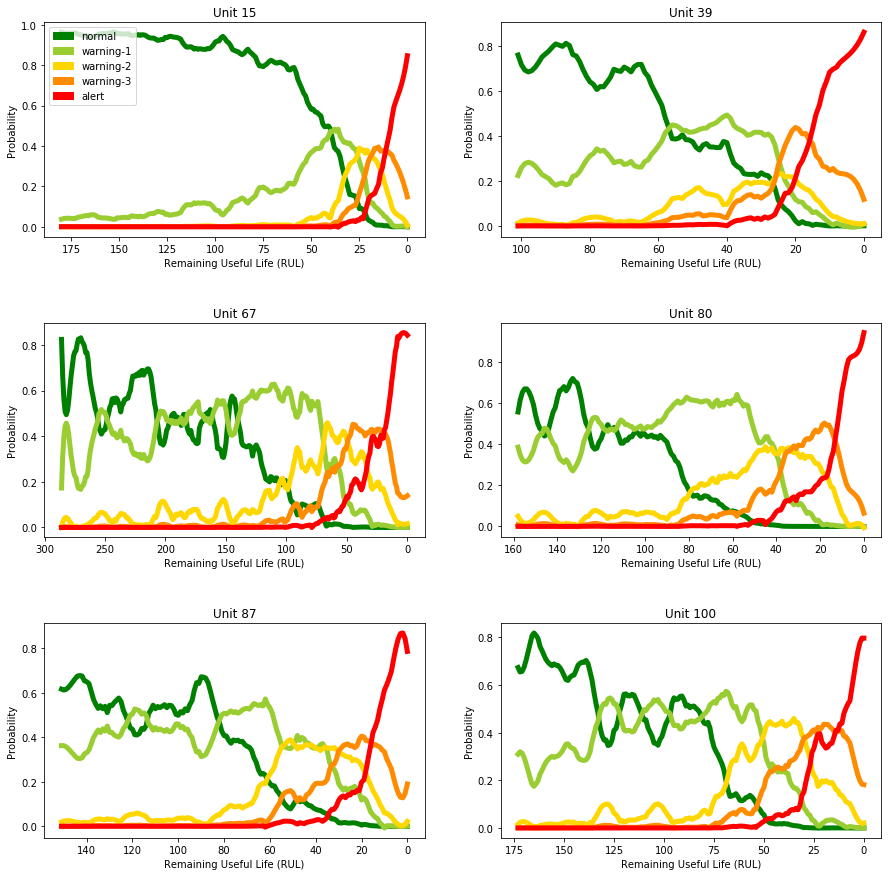

In [19]:
print("\n### Printing probabilities\n")
plot_probs("data/probs_deep_1.csv", units=[15, 39, 67, 80, 87, 100])

Visit www.add-for.com for more tutorials and updates.

This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License.